In [1]:
import pandas as pd
import numpy as np
import os
import logging
import time

import parse_genet
import sys
import getopt

import vi

import importlib

import simulate
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist

import scipy.stats

In [2]:
## original script from simulate.py
def simulate_sumstats(ld_blk, blk_size, n_gwas, p, prop_nz = 0.2, beta_sd = 0.1, sigma_noise = 1. ): 
    sigma_over_sqrt_n = sigma_noise / torch.sqrt(torch.tensor(n_gwas))
    nz = torch.rand(p) < prop_nz ## filter the snp with p threshold < prop_nz ## creating perfect annotation
    ## nz: the perfect annotaion (1 for causal, 0 for not); ## should add some noise here too
    beta_true = torch.where(nz, beta_sd * torch.randn(p), torch.zeros(p)) ## torch.randn = random normal distribution


    annotations = torch.stack([torch.ones(p),nz,torch.randn(p)]).T # intercept, useful annotation, random annotation

    beta_mrg = torch.zeros(p)
    mm = 0
    for kk in range(len(ld_blk)):
        idx_blk = torch.arange(mm,mm+blk_size[kk])
        ld_torch = torch.tensor(ld_blk[kk], dtype = torch.float)
        L, V = torch.linalg.eigh(ld_torch)
        L[L < 0.] = 0.

        beta_mrg[idx_blk] = ld_torch @ beta_true[idx_blk] + sigma_over_sqrt_n * (V @ torch.diag(L.sqrt())) @ torch.randn(blk_size[kk])
        #ld_torch @ beta_true[idx_blk], 
        # covariance_matrix = ld_torch * sigma_over_sqrt_n**2).rsample()
        mm += blk_size[kk]

    return beta_true, beta_mrg, annotations


In [3]:
chrom=22
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000,
    "anno" : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr22.annot.gz'
}

ref_df = parse_genet.parse_ref(param_dict['ref_dir'] + '/snpinfo_ukbb_hm3')

ref_df = ref_df[ref_df.CHR == chrom]
vld_df = parse_genet.parse_bim(param_dict['bim_prefix'] + ".bim")
vld_df = vld_df[vld_df.CHR == chrom]
sst_dict = parse_genet.parse_sumstats(ref_df, vld_df, param_dict['sst_file'], param_dict['n_gwas'])
ld_blk, ld_blk_sym, blk_size = parse_genet.parse_ldblk(param_dict['ref_dir'], sst_dict, chrom)                                                                                                                                                                                 
print("there are %d ld_blk" %(len(ld_blk)))

beta_true, beta_mrg, annotations = simulate.simulate_sumstats(ld_blk, blk_size, param_dict['n_gwas'], p = len(sst_dict))

... parse reference file: /gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur/snpinfo_ukbb_hm3 ...
... parse sumstats file: test_data/sumstats.txt ...
... 991 common SNPs in the reference, sumstats, and validation set ...
... parse reference LD on chromosome 22 ...
there are 4 ld_blk


In [6]:
ref_df


,index,CHR,SNP,BP,A1,A2,MAF
0,1101065,22,rs7287144,16886873,G,A,0.27220
1,1101066,22,rs5748662,16892858,A,G,0.27120
2,1101067,22,rs5747620,17032698,C,T,0.40470
3,1101068,22,rs9605903,17054720,C,T,0.27760
4,1101069,22,rs5747940,17056415,T,C,0.49070
...,...,...,...,...,...,...,...
16355,1117420,22,rs2285395,51178090,A,G,0.05199
16356,1117421,22,rs13056621,51181759,A,G,0.13070
16357,1117422,22,rs3888396,51211392,C,T,0.10210
16358,1117423,22,rs2238837,51212875,C,A,0.30240


## parse annotations

In [67]:
## adapt script from polyfun
logging.getLogger().setLevel(logging.INFO)
logging.info('Loading annotations file...')

anno_bl = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr22.annot.gz'

t0 = time.time()

## check anno exist
if not os.path.exists(anno_bl):
    raise IOError('Cannot find annotation file %s'%(anno_bl))

anno = pd.read_csv(anno_bl, compression='gzip',sep = '\t')
logging.info('Read %d annotations for %d SNPs'%(anno.shape[1]-5, anno.shape[0]))

anno_merge = sst_dict[['SNP']].merge(anno, on = 'SNP') 
logging.info('total %d SNPs after merging with sst'%(anno_merge.shape[0]))

#anno_torch= torch.tensor(anno_merge.iloc[:,5:].values) 
anno_torch = torch.cat((torch.ones((991,1)),torch.tensor(anno_merge.iloc[:,5:].values)), dim=1) ## because there are A1, A2, SNP, CHR, and BP
logging.info('Done in %0.2f seconds'%(time.time() - t0))

# is_annot_missing = ~(df_snps.index.isin(df_annot.index))
#     if np.any(is_annot_missing):
#         err_msg = 'The annotations of %d SNPs were not found in the annotation files'%(is_annot_missing.sum())
#         if args.allow_missing:
#             logging.warning(err_msg)
#             df_snps = df_snps.loc[~is_annot_missing]
#         else:
#             raise ValueError(err_msg + '. To proceed without these SNPs, use the flag --allow-missing')
            
#     #extract the annotations of the relevant SNPs
#     df_annot = df_snps[['PIP']].merge(df_annot, left_index=True, right_index=True)

#     #write output to file
#     logging.info('Writing annotations to %s'%(args.out))
#     if args.out.endswith('.parquet'):
#         df_annot.to_parquet(args.out, index=False)
#     else:
#         df_annot.to_csv(args.out, sep='\t', index=False, float_format='%0.4e')

INFO:root:Loading annotations file...
INFO:root:Read 5 annotations for 271699 SNPs
INFO:root:total 991 SNPs after merging with sst
INFO:root:Done in 0.56 seconds


In [5]:
anno_bl = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/annotations/annotations_high_h2/baseline/baseline_high_h2_chr22.annot.gz'
anno_torch = parse_genet.parse_anno(anno_bl, sst_dict)

... parse annotations ...
Read 5 annotations for 271699 SNPs
total 991 SNPs after merging with sst
Done in 0.55 seconds


In [6]:
anno[anno["baseline-H3K27ac_PGC2_common"] !=0].describe()

,CHR,BP,baseline-H3K27ac_PGC2_common,baseline-Transcr_Hoffman.flanking.500_common,baseline-Coding_UCSC_lowfreq,baseline-BLUEPRINT_H3K27acQTL_MaxCPP_common,baseline-GTEx_eQTL_MaxCPP_common
count,39385.0,3.938500e+04,39385.0,39385.000000,39385.0,39385.000000,39385.000000
mean,22.0,3.360178e+07,1.0,0.234099,0.0,0.033521,0.020585
std,0.0,1.024100e+07,0.0,0.423440,0.0,0.131245,0.110158
min,22.0,1.605082e+07,1.0,0.000000,0.0,0.000000,0.000000
25%,22.0,2.386188e+07,1.0,0.000000,0.0,0.000000,0.000000
50%,22.0,3.339809e+07,1.0,0.000000,0.0,0.000000,0.000000
75%,22.0,4.301954e+07,1.0,0.000000,0.0,0.000000,0.000000
max,22.0,5.123601e+07,1.0,1.000000,0.0,1.000000,1.000000


In [37]:
df_snps.iloc[:,5:10].values.ravel('K')

array([0., 0., 0., ..., 0., 0., 0.])

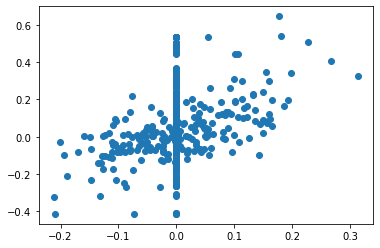

In [3]:
plt.scatter(beta_true, beta_mrg)

In [4]:
annotations

tensor([[ 1.0000,  0.0000, -1.5152],
        [ 1.0000,  1.0000,  0.7892],
        [ 1.0000,  0.0000, -0.3203],
        ...,
        [ 1.0000,  0.0000, -1.5114],
        [ 1.0000,  1.0000, -1.5003],
        [ 1.0000,  0.0000, -1.1544]])

def vi(
    sst_df, 
    n, 
    ld_blk, 
    blk_size, 
    device = "cpu",
    annotations = None,
    sigma_noise = None, 
    phi = None, 
    phi_as_prior = True,
    constrain_psi = True, 
    constrain_sigma = False,
    desired_min_eig = 1e-3, 
    **opt_kwargs
):

In [6]:
param_dict = {
    'ref_dir' : '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/LD_PRScs/ldblk_ukbb_eur', ## add my path
    'bim_prefix' : "test_data/test",
    'sst_file' : "test_data/sumstats.txt",
    'n_gwas' : 200000, 
    'out_dir' : "test_data",
    "seed" : 42, 
    "beta_std" : "False", 
    "n_iter" : 1000,
    'n_burnin': 500, 'thin': 5,'a': 1, 'b': 0.5, 'phi': None, 'chrom':22,
    "anno" : anno_torch
}


## vi 
logging.getLogger().setLevel(logging.INFO)
t0 = time.time()
vi_test = vi.vi( sst_dict, param_dict['n_gwas'], ld_blk, blk_size)        
logging.info('Done in %0.2f seconds'%(time.time() - t0))
#losses, beta, phi_est, stats = vi.vi(sst_dict, param_dict['n_gwas'], ld_blk, blk_size, device = device, annotations = None, max_iterations = param_dict['n_iter'], min_particles = 1, max_particles=4, desired_min_eig = 1e-3, min_iterations = 200, stall_window = 30, phi_as_prior = False, lr = 0.03, constrain_sigma = True)


... SVI ...
Degenerate LD mat (min eigenvalue=-4.234e-04), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-1.678e-03), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-2.295e-02), fixing to 1.000e-03
Degenerate LD mat (min eigenvalue=-8.785e-04), fixing to 1.000e-03
Done after 205 iterations. Increasing num_particles to 2.
Done after 59 iterations. Increasing num_particles to 4.
Done after 45 iterations. Increasing num_particles to 8.
Done after 47 iterations. Increasing num_particles to 16.


INFO:root:Done in 44.65 seconds


In [7]:
len(vi_test[0])

352

In [8]:
len(vi_test[1])  ## beta is per snp

991

In [9]:
vi_test[3].keys()

dict_keys(['sqrt_phi', 'sqrt_psi', 'sigma_noise', 'obs_0', 'obs_1', 'obs_2', 'obs_3', 'beta'])

In [26]:
anno_merge

,SNP,CHR,BP,A1,A2,baseline-H3K27ac_PGC2_common,baseline-Transcr_Hoffman.flanking.500_common,baseline-Coding_UCSC_lowfreq,baseline-BLUEPRINT_H3K27acQTL_MaxCPP_common,baseline-GTEx_eQTL_MaxCPP_common
0,rs9605903,22,17054720,T,C,0,0,0,0.0,0.00000
1,rs5746647,22,17057138,G,T,0,0,0,0.0,0.00000
2,rs5747999,22,17075353,C,A,0,1,0,0.0,0.00000
3,rs2845380,22,17203103,A,G,1,0,0,0.0,0.04618
4,rs2247281,22,17211075,G,A,0,1,0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...
986,rs5752681,22,20774808,G,A,1,1,0,0.0,0.00000
987,rs1771146,22,20775247,C,T,1,0,0,0.0,0.00000
988,rs6005740,22,20776843,G,A,1,1,0,0.0,0.00000
989,rs738084,22,20778066,A,G,1,0,0,0.0,0.00000
